In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from pycbc.frame import read_frame

In [15]:
psd_paths = ['/media/bedelman/SSD2/data/GWTC-1_psds/GWTC1_Data/GW151012/psds/H1_GW151012-PSD.dat', 
             '/media/bedelman/SSD2/data/GWTC-1_psds/GWTC1_Data/GW151012/psds/L1_GW151012-PSD.dat']
frame_paths = ['/media/bedelman/SSD2/data/GWTC-1_psds/GWTC1_Data/GW151012/frames/H-H1_GWOSC_4KHZ_R1-1128678885-32.gwf', 
               '/media/bedelman/SSD2/data/GWTC-1_psds/GWTC1_Data/GW151012/frames/L-L1_GWOSC_4KHZ_R1-1128678885-32.gwf']
ifos = ['H1', 'L1']
srate = 2048.*2.
seglen = 32.
df = 1/32.
N = int(float(srate)*float(seglen) / 2. + 1)

In [16]:
f_line = 506
width = 50
Q = f_line / width
f_line_2 = 60
width_2 = 6
Q2 = f_line_2 / width_2

In [17]:
b, a  = signal.iirnotch(f_line, Q, srate)
b2, a2 = signal.iirnotch(f_line_2, Q2, srate)

In [18]:
freq, h = signal.freqz(b, a, fs=srate, worN=N)
freq2, h2 = signal.freqz(b2, a2, fs=srate, worN=N)

In [6]:
fig, ax = plt.subplots(2, 1, figsize=(8, 6))
ax[0].plot(freq, 20*np.log10(abs(h))+20*np.log10(abs(h2)), color='blue')
ax[0].set_title("Frequency Response")
ax[0].set_ylabel("Amplitude (dB)", color='blue')
ax[0].set_xlim([10., 1024.])
ax[0].set_xscale('log')
ax[0].grid()
ax[1].plot(freq, np.unwrap(np.angle(h))*180/np.pi+np.unwrap(np.angle(h2))*180/np.pi, color='green')
ax[1].set_ylabel("Angle (degrees)", color='green')
ax[1].set_xlabel("Frequency (Hz)")
ax[1].set_xlim([10., 1024.])
ax[1].set_xscale('log')
ax[1].grid()
plt.show()

/home/bedelman/.virtualenvs/gw-postprocess/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


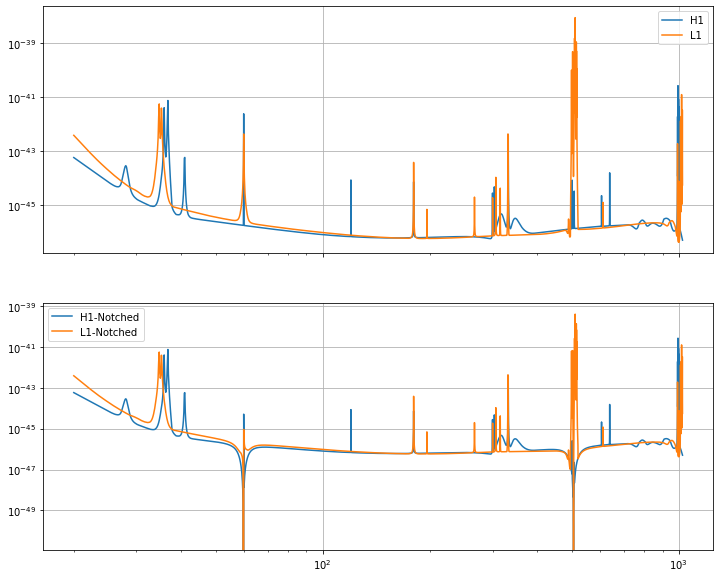

In [7]:
fig, axs = plt.subplots(nrows=2, ncols=1, sharex='all', figsize=(12, 10))
for path, ifo in zip(psd_paths, ifos):
    f, psd = np.genfromtxt(path, unpack=True)
    sel = freq > f[0]
    axs[0].loglog(f, psd, label=f'{ifo}')
    axs[1].loglog(f, psd*h[sel]*h2[sel], label=f'{ifo}-Notched')
axs[1].legend()
axs[0].legend()
axs[1].grid()
axs[0].grid()
plt.savefig('Notched_psds_f0_505_Q-5.png', dpi=400)

In [19]:
trigtime = 1128678900.4
seglen = 8
hts = read_frame(frame_paths[0], 'H1:GWOSC-4KHZ_R1_STRAIN', start_time=1128678885, duration=32)
lts = read_frame(frame_paths[1], 'L1:GWOSC-4KHZ_R1_STRAIN', start_time=1128678885, duration=32)

In [20]:
from scipy.signal import tukey

def window(ts, seglen, a=0.6):
    window = tukey(len(ts), alpha=a/seglen)
    return ts*window

In [21]:
hts = window(hts, seglen)
lts = window(hts, seglen)

In [22]:
hfs = hts.to_frequencyseries(delta_f=1./32.)
lfs = lts.to_frequencyseries(delta_f=1./32.)

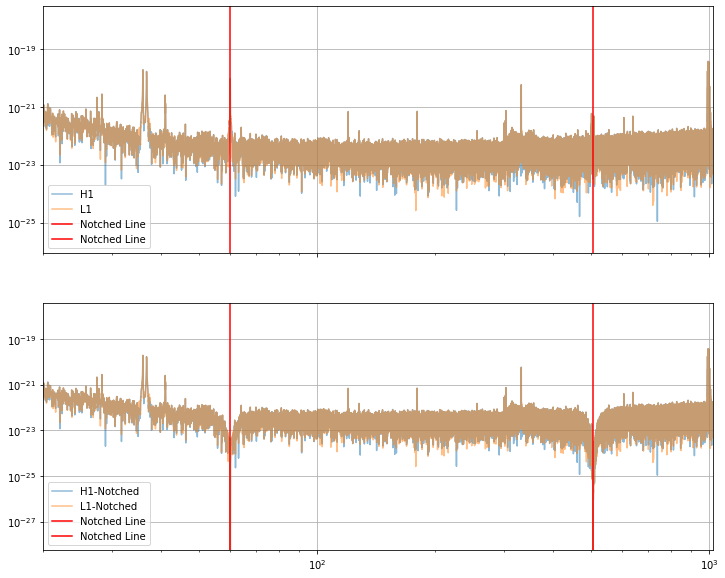

In [23]:
fig, axs = plt.subplots(nrows=2, ncols=1, sharex='all', figsize=(12, 10))
for fs, ifo in zip([hfs, lfs], ifos):
    axs[0].loglog(fs.sample_frequencies, np.abs(fs), label=f'{ifo}', alpha=0.5)
    sel = fs.sample_frequencies <= freq[-1]
    axs[1].loglog(fs.sample_frequencies[sel], np.abs(fs[sel])*h[:-1]*h2[:-1], label=f'{ifo}-Notched', alpha=0.5)
for line in [60, 506]:
    axs[0].axvline(line, color='r', linestyle='-', label='Notched Line')
    axs[1].axvline(line, color='r', linestyle='-', label='Notched Line')
axs[1].legend()
axs[0].legend()
axs[1].grid()
axs[0].grid()
axs[0].set_xlim(20., 1024.)
plt.savefig('Notched_frames_f0_505_Q-5.png', dpi=400)

In [24]:
from pycbc.types import FrequencySeries

In [25]:
epoch = hfs.epoch
hfs = FrequencySeries(hfs[sel]*h[:-1]*h2[:-1], epoch=epoch, delta_f=1./seglen)
lfs = FrequencySeries(lfs[sel]*h[:-1]*h2[:-1], epoch=epoch, delta_f=1./seglen)

In [27]:
hts = hfs.to_timeseries()
lts = hfs.to_timeseries()

In [28]:
from pycbc.frame import write_frame

In [29]:
write_frame('/media/bedelman/SSD2/data/GWTC-1_psds/GWTC1_Data/GW151012/frames/H-H1_GWOSC-4KHZ-R1_NOTCHED-1128678885-32.gwf', 
           'H1:GWOSC-4KHZ_R1_STRAIN', hts)
write_frame('/media/bedelman/SSD2/data/GWTC-1_psds/GWTC1_Data/GW151012/frames/L-L1_GWOSC-4KHZ-R1_NOTCHED-1128678885-32.gwf', 
           'L1:GWOSC-4KHZ_R1_STRAIN', lts)